In [1]:
import sys
import matplotlib.pyplot as plt
import h5py
from tqdm import tqdm
import librosa
import numpy as np
from keras.utils.np_utils import to_categorical
from sklearn.utils import shuffle
import cv2
import torch
import torchaudio

from tools import prepare, mixup, preprocess, noise, getCorrects

classes = {
    #"Rhinolophus capensis": 0,
    #"Rhinolophus smithersi": 1,
    #"Rhinolophus clivosus": 2,
    #"Rhinolophus simulator": 3,
    #"Myotis tricolor": 4,
    #"Myotis welwitschii": 5,
    "Pipistrellus hesperidus": 0,
    #"Eptesicus hottentotus": 7,
    #"Minopterus natalensis": 8,
    #"Taphozous mauritianus": 9,
    #"Scotophilus dinganii": 10,
    "Cistugo lesueuri": 1,
    "Laephotis capensis": 2,
    #"Rousettus aegyptiacus": 13,
    "Chaerephon pumilus": 3,
    "Tadarida aegyptiaca": 4,
    #"Vespertilionidae": 16,
    #"Kerivoula": 17,
    #"Pesticide Spray": 18,
    #"Unlabeled": 5,
}

2022-12-23 10:22:00.831975: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-23 10:22:01.233733: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-23 10:22:04.108075: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ffundel/.local/lib:
2022-12-23 10:22:04.108393: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cann

# Dataset

In [2]:
num_bands = 257
max_len = 60
seq_len = (max_len + 1) * 2816      # = 250ms ~ 25ms (0.5 * 44 * (512 // 4))
seq_skip = int(max_len / 4) * 2816     # 15 patches = 15 * 0.25 * 22050 * 0.5
patch_len = 44
patch_skip = 22

data_path = "./data/prepared_signal.h5"
X_train, Y_train, X_test, Y_test, X_val, Y_val = prepare(data_path, classes, seq_len, seq_skip)

100%|█████████████████████████████████████████████| 8/8 [00:02<00:00,  3.08it/s]


In [3]:
print("Total sequences:", len(X_train) + len(X_test) + len(X_val))
print("Train sequences:", X_train.shape, Y_train.shape)
print("Test sequences:", X_test.shape, Y_test.shape)
print("Validation sequences:", X_val.shape, Y_val.shape)

Total sequences: 30301
Train sequences: (17636, 171776) (17636, 5)
Test sequences: (7609, 171776) (7609, 5)
Validation sequences: (5056, 171776) (5056, 5)


# Model

In [4]:
import time
import datetime
import torch
import torch.nn as nn
import math
from torch.cuda.amp import autocast
from torch.utils.data import TensorDataset, DataLoader

from torchsummary import summary
from torchmetrics.functional import f1_score

from SAM import SAM
from ASL import AsymmetricLoss
from BigBAT import BigBAT

/home/ffundel/.local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/ffundel/.local/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model, device_ids=[0, 1])

In [6]:
patch_embedding = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(5, 7), stride=(2, 3), padding=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

            nn.Conv2d(16, 32, kernel_size=(3, 5), stride=(2, 3), padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=5, stride=2, padding=1),

            nn.Conv2d(32, 64, kernel_size=(3, 5), stride=(1, 2), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        ).to(device)

big_patch_embedding = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(3, 5), stride=(2, 3), padding=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

            nn.Conv2d(16, 32, kernel_size=(3, 5), stride=(2, 3), padding=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    
            nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 3), padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=5, stride=2, padding=1),

            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 3), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
    
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        ).to(device)

summary(big_patch_embedding, (1, 44, 257))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 24, 87]             256
       BatchNorm2d-2           [-1, 16, 24, 87]              32
              ReLU-3           [-1, 16, 24, 87]               0
            Conv2d-4           [-1, 32, 14, 30]           7,712
       BatchNorm2d-5           [-1, 32, 14, 30]              64
              ReLU-6           [-1, 32, 14, 30]               0
         MaxPool2d-7            [-1, 32, 7, 15]               0
            Conv2d-8             [-1, 32, 4, 5]           9,248
       BatchNorm2d-9             [-1, 32, 4, 5]              64
             ReLU-10             [-1, 32, 4, 5]               0
           Conv2d-11             [-1, 64, 2, 2]          18,496
      BatchNorm2d-12             [-1, 64, 2, 2]             128
             ReLU-13             [-1, 64, 2, 2]               0
           Conv2d-14             [-1, 6

In [7]:
batch_size = 64
epochs = 10
lr = .0005
warmup_epochs = 5
d_model = 64

nhead = 2
dim_feedforward = 32
num_layers = 2
dropout = 0.3
classifier_dropout = 0.3
num_classes = len(list(classes))
    
model = BigBAT(
    max_len=max_len,
    patch_len=patch_len,
    patch_skip=patch_skip,
    d_model=d_model,
    num_classes=len(list(classes)),
    patch_embedding=big_patch_embedding,
    nhead=nhead,
    dim_feedforward=dim_feedforward,
    num_layers=num_layers,
    dropout=dropout,
    classifier_dropout=classifier_dropout,
)

model.to(device)
print(device)

cuda:0


In [8]:
## This is the unsupervised pretraining section
## Here we initialize the model by loading weights from a unsupervised model

unsup_type = 'ae_full' # choose from 'skiba_pre', ae_embed', 'ae_full', 'sup_contrast', 'sim_clr'

if unsup_type == 'ae_embed':
    pretrained_dict = torch.load('BigBAT-embedding-petrain.pth') #pretrained model keys
    model_dict = model.patch_embedding.state_dict() #new model keys
    processed_dict = {}

    for k in pretrained_dict.keys(): 
        decomposed_key = k.split(".")
        if("encode" in decomposed_key):
            pretrained_key = ".".join(decomposed_key[1:])
            processed_dict[pretrained_key] = pretrained_dict[k] #Here we are creating the new state dict to make our new model able to load the pretrained parameters without the head.
    print(processed_dict.keys())
    model.patch_embedding.load_state_dict(processed_dict, strict=False)
    
elif unsup_type == 'ae_full':
    pretrained_dict = torch.load('BigBAT-petrain.pth') #pretrained model keys
    model_dict = model.state_dict() #new model keys
    processed_dict = {}

    for k in pretrained_dict.keys(): 
        decomposed_key = k.split(".")
        if "BATencode" in decomposed_key:
            pretrained_key = ".".join(decomposed_key[1:])
            if "classifier" in decomposed_key:
                processed_dict[pretrained_key] = model_dict[pretrained_key]
            else:
                processed_dict[pretrained_key] = pretrained_dict[k] #Here we are creating the new state dict to make our new model able to load the pretrained parameters without the head.
    print(processed_dict.keys())
    model.load_state_dict(processed_dict, strict=False)

if unsup_type == 'skiba_pre':
    pretrained_dict = torch.load('BigBAT_skiba_pretrained.pth') #pretrained model keys
    model_dict = model.state_dict() #new model keys
    processed_dict = {}
    
    for k in pretrained_dict.keys(): 
        decomposed_key = k.split(".")
        if "classifier" in decomposed_key:
            processed_dict[k] = model_dict[k]
        else:
            processed_dict[k] = pretrained_dict[k] #Here we are creating the new state dict to make our new model able to load the pretrained parameters without the head.
    print(processed_dict.keys())
    model.load_state_dict(processed_dict, strict=False)

dict_keys(['cls_token', 'pos_encoder', 'patch_embedding.0.weight', 'patch_embedding.0.bias', 'patch_embedding.1.weight', 'patch_embedding.1.bias', 'patch_embedding.1.running_mean', 'patch_embedding.1.running_var', 'patch_embedding.1.num_batches_tracked', 'patch_embedding.3.weight', 'patch_embedding.3.bias', 'patch_embedding.4.weight', 'patch_embedding.4.bias', 'patch_embedding.4.running_mean', 'patch_embedding.4.running_var', 'patch_embedding.4.num_batches_tracked', 'patch_embedding.7.weight', 'patch_embedding.7.bias', 'patch_embedding.8.weight', 'patch_embedding.8.bias', 'patch_embedding.8.running_mean', 'patch_embedding.8.running_var', 'patch_embedding.8.num_batches_tracked', 'patch_embedding.10.weight', 'patch_embedding.10.bias', 'patch_embedding.11.weight', 'patch_embedding.11.bias', 'patch_embedding.11.running_mean', 'patch_embedding.11.running_var', 'patch_embedding.11.num_batches_tracked', 'patch_embedding.13.weight', 'patch_embedding.13.bias', 'patch_embedding.14.weight', 'patc

In [9]:
freq_masking = torchaudio.transforms.FrequencyMasking(freq_mask_param=50)
time_masking = torchaudio.transforms.TimeMasking(time_mask_param=50)

In [10]:
train_len = batch_size * int(len(X_train) / batch_size)
test_len = batch_size * int(len(X_test) / batch_size)
val_len = batch_size * int(len(X_val) / batch_size)

train_data = TensorDataset(torch.Tensor(X_train[:train_len]), torch.from_numpy(Y_train[:train_len]))
test_data = TensorDataset(torch.Tensor(X_test[:test_len]), torch.from_numpy(Y_test[:test_len]))
val_data = TensorDataset(torch.Tensor(X_val[:val_len]), torch.from_numpy(Y_val[:val_len]))

train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)

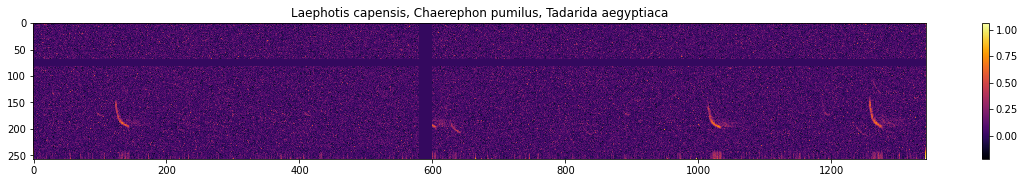

In [11]:
def plot_sequence(X, Y, k):
    plt.figure(figsize = (20, 2.5))
    x = X[k].cpu().detach().numpy()
    y = Y[k].cpu().detach().numpy()
    plt.imshow(np.rot90(x), interpolation='nearest', aspect='auto', cmap='inferno')
    plt.colorbar()
    label_list = []
    if(len(y.shape) > 0):
        for i in np.argwhere(y == 1)[:,0]:
            label_list.append(list(classes)[i])
        plt.title(", ".join(label_list))
    else:
        plt.title(list(classes)[y])

k = np.random.randint(0, batch_size)
X1, Y1 = next(iter(train_loader))
X1, Y1 = X1.cuda(), Y1.cuda()
X1, Y1 = mixup(X1, Y1, num_classes=num_classes, min_seq=1, max_seq=3)
X1 = preprocess(X1)
X1 = noise(X1)
X1 = freq_masking(X1)
X1 = time_masking(X1)

plot_sequence(X1, Y1, k)

In [12]:
criterion = AsymmetricLoss(gamma_neg=2, gamma_pos=1, clip=0)

base_optimizer = torch.optim.SGD
optimizer = SAM(model.parameters(), base_optimizer, lr=lr, momentum=0.9)
    
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer=optimizer, T_0=warmup_epochs)

min_val_loss = np.inf

torch.autograd.set_detect_anomaly(True)

In [13]:
def smoothen(y, num_classes, l=.02):
    return y * (1.0 - l) + (y.sum(dim=1, keepdim=True) * l / num_classes).repeat(1, num_classes)

def getSpeciesMasks(species):
    masks = torch.eye(len(species))
    for i, s in enumerate(species):
        genus = s.split(' ')[0]
        for k, ss in enumerate(species):
            if ss.startswith(genus):
                masks[i, k] = 1
        masks[i, i] = 0
    return masks

def speciesSmoothing(Y, masks, l=.1):
    ny = torch.zeros_like(Y)
    for i, y in enumerate(Y):
        lbl = torch.nonzero(y)
        ny[i] = y * (1.0 - l) + masks[lbl].sum(0) * (y.sum() * l / max(masks[lbl].sum(), 1))
    return ny

masks = getSpeciesMasks(list(classes)).to(device)

In [14]:
def train_epoch(model, epoch, criterion, optimizer, scheduler, dataloader, device):
    model.train()
    
    running_loss = 0.0
    running_corrects = 0
    
    num_batches = len(dataloader)
    num_samples = len(dataloader.dataset)
    
    for batch, (inputs, labels) in enumerate(tqdm(dataloader)):
        # Transfer Data to GPU if available
        inputs, labels = inputs.to(device), labels.to(device)
        inputs, labels = mixup(inputs, labels, num_classes, min_seq=1, max_seq=3, p_min=0.3)
        inputs = preprocess(inputs)
        #inputs = noise(inputs)
        #inputs = freq_masking(inputs)
        #inputs = time_masking(inputs)
        #labels = smoothen(labels, num_classes)
        labels = speciesSmoothing(labels, masks)
        labels = smoothen(labels, num_classes)
         
        # Clear the gradients
        optimizer.zero_grad()
        
        # Forward Pass
        inputs[torch.isnan(inputs)] = 0
        inputs[torch.isinf(inputs)] = 0
        outputs = model(inputs)

        # Compute Loss (ASL)
        labels[torch.isnan(labels)] = 0
        outputs[torch.isnan(outputs)] = 0
        labels[torch.isinf(labels)] = 0
        outputs[torch.isinf(outputs)] = 0
        loss = criterion(outputs, labels)
        
        # Calculate gradients
        loss.backward()
        
        # Update Weights (SAM)
        optimizer.first_step()
        criterion(model(inputs), labels).backward()
        optimizer.second_step()
        
        # Calculate Loss
        running_loss += loss.item() * inputs.size(0)
        running_corrects += getCorrects(outputs, labels)
    
        # Perform learning rate step
        scheduler.step(epoch + batch / num_batches)
            
    epoch_loss = running_loss / num_samples
    epoch_acc = running_corrects / num_samples
    
    return epoch_loss, epoch_acc

In [15]:
def test_epoch(model, epoch, criterion, optimizer, dataloader, device):
    model.eval()
    
    num_batches = len(dataloader)
    num_samples = len(dataloader.dataset)
    
    with torch.no_grad():
        running_loss = 0.0
        running_corrects = 0

        for batch, (inputs, labels) in enumerate(tqdm(dataloader)):
            # Transfer Data to GPU if available
            inputs, labels = inputs.to(device), labels.to(device)
            inputs, labels = mixup(inputs, labels, num_classes, min_seq=1, max_seq=3)
            inputs = preprocess(inputs)

            # Clear the gradients
            optimizer.zero_grad()

            # Forward Pass
            outputs = model(inputs)

            # Compute Loss
            loss = criterion(outputs, labels)

            # Calculate Loss
            running_loss += loss.item() * inputs.size(0)
            running_corrects += getCorrects(outputs, labels)

        epoch_loss = running_loss / num_samples
        epoch_acc = running_corrects / num_samples
    
    return epoch_loss, epoch_acc

# Training

In [16]:
import wandb

wandb_config = {
    "epochs": epochs,
    "lr": lr,
    "batch_size": batch_size,
    "warmup_epochs": warmup_epochs,
    "d_model": d_model,
    "nhead": nhead,
    "dim_feedforward": dim_feedforward,
    "num_layers": num_layers,
    "dropout": dropout,
    "classifier_dropout": classifier_dropout
}

wandb.init(project="BigBAT-UFS", entity="frankfundel", config=wandb_config)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: frankfundel (use `wandb login --relogin` to force relogin)
2022-12-23 10:23:44.028085: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-23 10:23:44.480112: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-23 10:23:47.172783: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory

In [17]:
restart_scheduler = 5
s_epoch = 0
for epoch in range(epochs):
    end = time.time()
    print(f"==================== Starting at epoch {epoch} ====================", flush=True)
    
    train_loss, train_acc = train_epoch(model, s_epoch, criterion, optimizer, scheduler, train_loader, device)
    print('Training loss: {:.4f} Acc: {:.4f}'.format(train_loss, train_acc), flush=True)
    
    val_loss, val_acc = test_epoch(model, s_epoch, criterion, optimizer, val_loader, device)
    print('Validation loss: {:.4f} Acc: {:.4f}'.format(val_loss, val_acc), flush=True)
    
    wandb.log({
        "train_loss": train_loss,
        "train_acc": train_acc,
        "val_loss": val_loss,
        "val_acc": val_acc,
    })
    
    if min_val_loss > val_loss:
        print('val_loss decreased, saving model', flush=True)
        min_val_loss = val_loss
        
        # Saving State Dict
        torch.save(model.state_dict(), 'BigBAT.pth')
    
    if s_epoch == restart_scheduler:
        s_epoch = 0
    else:
        s_epoch += 1

==================== Starting at epoch 0 ====================


100%|█████████████████████████████████████████| 275/275 [03:58<00:00,  1.15it/s]

Training loss: 45.0214 Acc: 0.6326



100%|███████████████████████████████████████████| 79/79 [00:25<00:00,  3.08it/s]

Validation loss: 38.3200 Acc: 0.6555
val_loss decreased, saving model
==================== Starting at epoch 1 ====================



100%|█████████████████████████████████████████| 275/275 [03:58<00:00,  1.16it/s]

Training loss: 33.7425 Acc: 0.7711



100%|███████████████████████████████████████████| 79/79 [00:25<00:00,  3.10it/s]

Validation loss: 34.3020 Acc: 0.7191
val_loss decreased, saving model
==================== Starting at epoch 2 ====================



100%|█████████████████████████████████████████| 275/275 [04:09<00:00,  1.10it/s]

Training loss: 31.2835 Acc: 0.7969



100%|███████████████████████████████████████████| 79/79 [00:26<00:00,  3.03it/s]

Validation loss: 30.8485 Acc: 0.7803
val_loss decreased, saving model
==================== Starting at epoch 3 ====================



100%|█████████████████████████████████████████| 275/275 [04:10<00:00,  1.10it/s]

Training loss: 29.5376 Acc: 0.8119



100%|███████████████████████████████████████████| 79/79 [00:30<00:00,  2.58it/s]

Validation loss: 30.0500 Acc: 0.7944
val_loss decreased, saving model
==================== Starting at epoch 4 ====================



100%|█████████████████████████████████████████| 275/275 [04:04<00:00,  1.12it/s]

Training loss: 28.7926 Acc: 0.8183



100%|███████████████████████████████████████████| 79/79 [00:32<00:00,  2.46it/s]

Validation loss: 29.2622 Acc: 0.7909
val_loss decreased, saving model
==================== Starting at epoch 5 ====================



100%|█████████████████████████████████████████| 275/275 [04:04<00:00,  1.12it/s]

Training loss: 30.6159 Acc: 0.8023



100%|███████████████████████████████████████████| 79/79 [00:30<00:00,  2.63it/s]

Validation loss: 34.4532 Acc: 0.6979
==================== Starting at epoch 6 ====================



100%|█████████████████████████████████████████| 275/275 [04:06<00:00,  1.12it/s]

Training loss: 30.0601 Acc: 0.8076



100%|███████████████████████████████████████████| 79/79 [00:25<00:00,  3.12it/s]

Validation loss: 32.4651 Acc: 0.7535
==================== Starting at epoch 7 ====================



100%|█████████████████████████████████████████| 275/275 [04:07<00:00,  1.11it/s]

Training loss: 29.4358 Acc: 0.8152



100%|███████████████████████████████████████████| 79/79 [00:26<00:00,  2.98it/s]

Validation loss: 30.7020 Acc: 0.7951
==================== Starting at epoch 8 ====================



100%|█████████████████████████████████████████| 275/275 [04:08<00:00,  1.11it/s]

Training loss: 28.3979 Acc: 0.8228



100%|███████████████████████████████████████████| 79/79 [00:26<00:00,  2.97it/s]

Validation loss: 29.2093 Acc: 0.7861
val_loss decreased, saving model
==================== Starting at epoch 9 ====================



100%|█████████████████████████████████████████| 275/275 [04:03<00:00,  1.13it/s]

Training loss: 27.3604 Acc: 0.8295



100%|███████████████████████████████████████████| 79/79 [00:33<00:00,  2.39it/s]

Validation loss: 28.6384 Acc: 0.8097
val_loss decreased, saving model


In [18]:
# Load after training
model.load_state_dict(torch.load('BigBAT.pth'))

<All keys matched successfully>

# Evaluation

In [19]:
mixed_corrects = 0.0
repeats = 5

predictions = []
targets = []

for r in range(repeats):
    # iterate over test data
    for inputs, labels in tqdm(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        inputs, labels = mixup(inputs, labels, num_classes, min_seq=1, max_seq=3)
        inputs = preprocess(inputs)

        output = model(inputs) # Feed Network
        predictions.extend(output.data.cpu().numpy())
        targets.extend(labels.data.cpu().numpy())
        mixed_corrects += getCorrects(output, labels)

100%|█████████████████████████████████████████| 118/118 [00:36<00:00,  3.21it/s]


In [20]:
from sklearn.metrics import f1_score

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

mixed_test_acc = mixed_corrects / (repeats * len(test_data))
mixed_f1_micro = f1_score(sigmoid(np.asarray(predictions)) > 0.5, np.asarray(targets), average='micro')
mixed_f1_macro = f1_score(sigmoid(np.asarray(predictions)) > 0.5, np.asarray(targets), average='macro')

print("Mixed test acc:", mixed_test_acc)
print("Mixed f1 micro:", mixed_f1_micro)
print("Mixed f1 macro:", mixed_f1_macro)

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_params, "params")

Mixed test acc: tensor(0.8146, device='cuda:0')
Mixed f1 micro: 0.892229941461203
Mixed f1 macro: 0.7694632912024477
102885 params


In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

Y_pred = []
Y_true = []
corrects = 0

model.eval()

# iterate over test data
for inputs, labels in tqdm(test_loader):
    inputs, labels = inputs.to(device), labels.to(device)
    inputs = preprocess(inputs)
    
    output = model(inputs) # Feed Network

    output = torch.argmax(output, 1).data.cpu().numpy()
    Y_pred.extend(output) # Save Prediction

    #labels = torch.argmax(labels, 1).data.cpu().numpy()
    labels = labels.data.cpu().numpy()
    Y_true.extend(labels) # Save Truth

100%|█████████████████████████████████████████| 118/118 [00:22<00:00,  5.16it/s]


In [22]:
# Filter out mixed
Y_pred2 = []
Y_true2 = []
for i, y in enumerate(Y_true):
    if y.sum() == 1:
        Y_true2.append(np.argmax(y))
        Y_pred2.append(Y_pred[i])
Y_pred = Y_pred2
Y_true = Y_true2

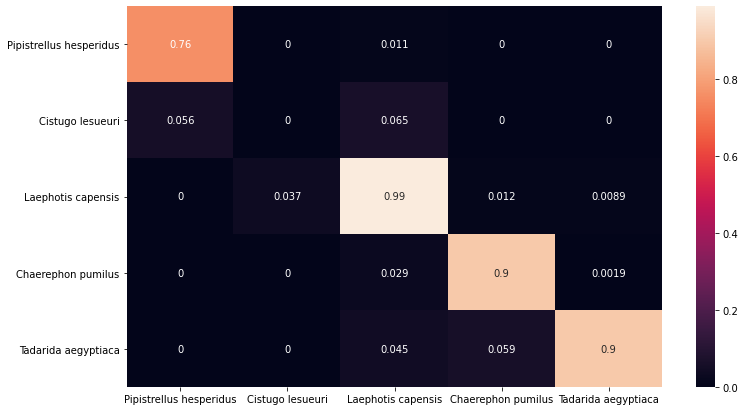

In [23]:
# Build confusion matrix
cf_matrix = confusion_matrix(Y_true, Y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=-1), index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (12, 7))
sn.heatmap(df_cm, annot=True)
plt.savefig('BigBAT.png')

In [28]:
print(cf_matrix)
print(np.sum(cf_matrix, axis=-1))

[[ 122    0   39    0    0]
 [   9    0  234    0    0]
 [   0    9 3572   12   19]
 [   0    0  103  931    4]
 [   0    0  161   61 1919]]
[ 161  243 3612 1038 2141]


In [24]:
corrects = np.equal(Y_pred, Y_true).sum()
single_test_acc = corrects / len(Y_pred)
single_f1 = f1_score(Y_true, Y_pred, average=None).mean()

print("Single test accuracy:", single_test_acc)
print("Single F1-score:", single_f1)

Single test accuracy: 0.9095205003474636
Single F1-score: 0.7225462827830784


In [25]:
wandb.log({
    "mixed_test_acc": mixed_test_acc,
    "mixed_f1_micro": mixed_f1_micro,
    "mixed_f1_macro": mixed_f1_macro,
    "single_test_acc": single_test_acc,
    "single_f1_micro": single_f1,
    "num_params": pytorch_total_params,
})

wandb.finish()

mixed_f1_macro,▁
mixed_f1_micro,▁
mixed_test_acc,▁
num_params,▁
single_f1_micro,▁
single_test_acc,▁
train_acc,▁▆▇▇█▇▇▇██
train_loss,█▄▃▂▂▂▂▂▁▁
val_acc,▁▄▇▇▇▃▅▇▇█
val_loss,█▅▃▂▁▅▄▂▁▁
mixed_f1_macro,0.76946
